In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

2023-08-23 09:50:21.166921: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-23 09:50:21.168539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 09:50:21.200637: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 09:50:21.201228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 09:50:21.817651: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
from modules.time_synth.tools import plot_series, plot_series_on_axis
from modules.data.loader import windowed_dataset, load_dataset,split
from modules.data.visualization import predict_and_plot
from models import init_default_fcnt, init_default_fcn, init_default_resnet

## Load some data from dataset

In [3]:
from binance.client import Client
from modules.data.remote import get_binance_historical_data
# For data preprocessing and analysis part
START_DATE = "1 Jun, 2023"
INTERVAL = Client.KLINE_INTERVAL_15MINUTE

data = get_binance_historical_data("BTCUSDT", INTERVAL, START_DATE)
classes = ['ascending triangle', 'base', 'descending triangle', 'symmetric triangle']

In [15]:
DATA_FOR_PREDICTION = 'Close'
WINDOW_SIZE = 200

prices = data[DATA_FOR_PREDICTION]
dataset = windowed_dataset(prices, WINDOW_SIZE, 1, normalize_window=True)

## Init model

In [5]:
model = init_default_fcnt(len(classes))

model(np.zeros((1,WINDOW_SIZE,1)))

model.load_weights("../static/models/fcnt_reverent_raman.h5")

## Make predictions

In [18]:
output = model.predict(dataset)

7801/7801 [==============================] - 36s 5ms/step


## Plot predictions

In [27]:
def draw_grid(windowed_dataset, window_size, output: np.ndarray, classes: list, skip_after_found=100, subplot_grid=(4,4), save_file='', threshold=0.75):
    skip = 0
    total = 1

    plt.subplots_adjust(hspace=0.5)

    for window, pred in zip(windowed_dataset, output[0]):    
        if skip:
            skip -= 1
            continue

        if total > subplot_grid[0] * subplot_grid[1]:
            break
        
        #window = tf.reshape(window, (window_size,)).numpy()
        
        if (np.argmax(pred) != 1) and (np.max(pred) > threshold):
            plt.subplot(*subplot_grid, total)
            predict_and_plot(model, window, title="{}\n {:.2f}".format(classes[np.argmax(pred)], np.max(pred)), show=False)
            #plot_series(range(len(window)), window,  show=False, title="{}\n {:.2f}".format(classes[np.argmax(pred)], np.max(pred)) )
            skip = skip_after_found
            total+=1
    
    plt.tight_layout() 

    if save_file:
        plt.savefig(save_file)
    
    plt.show()



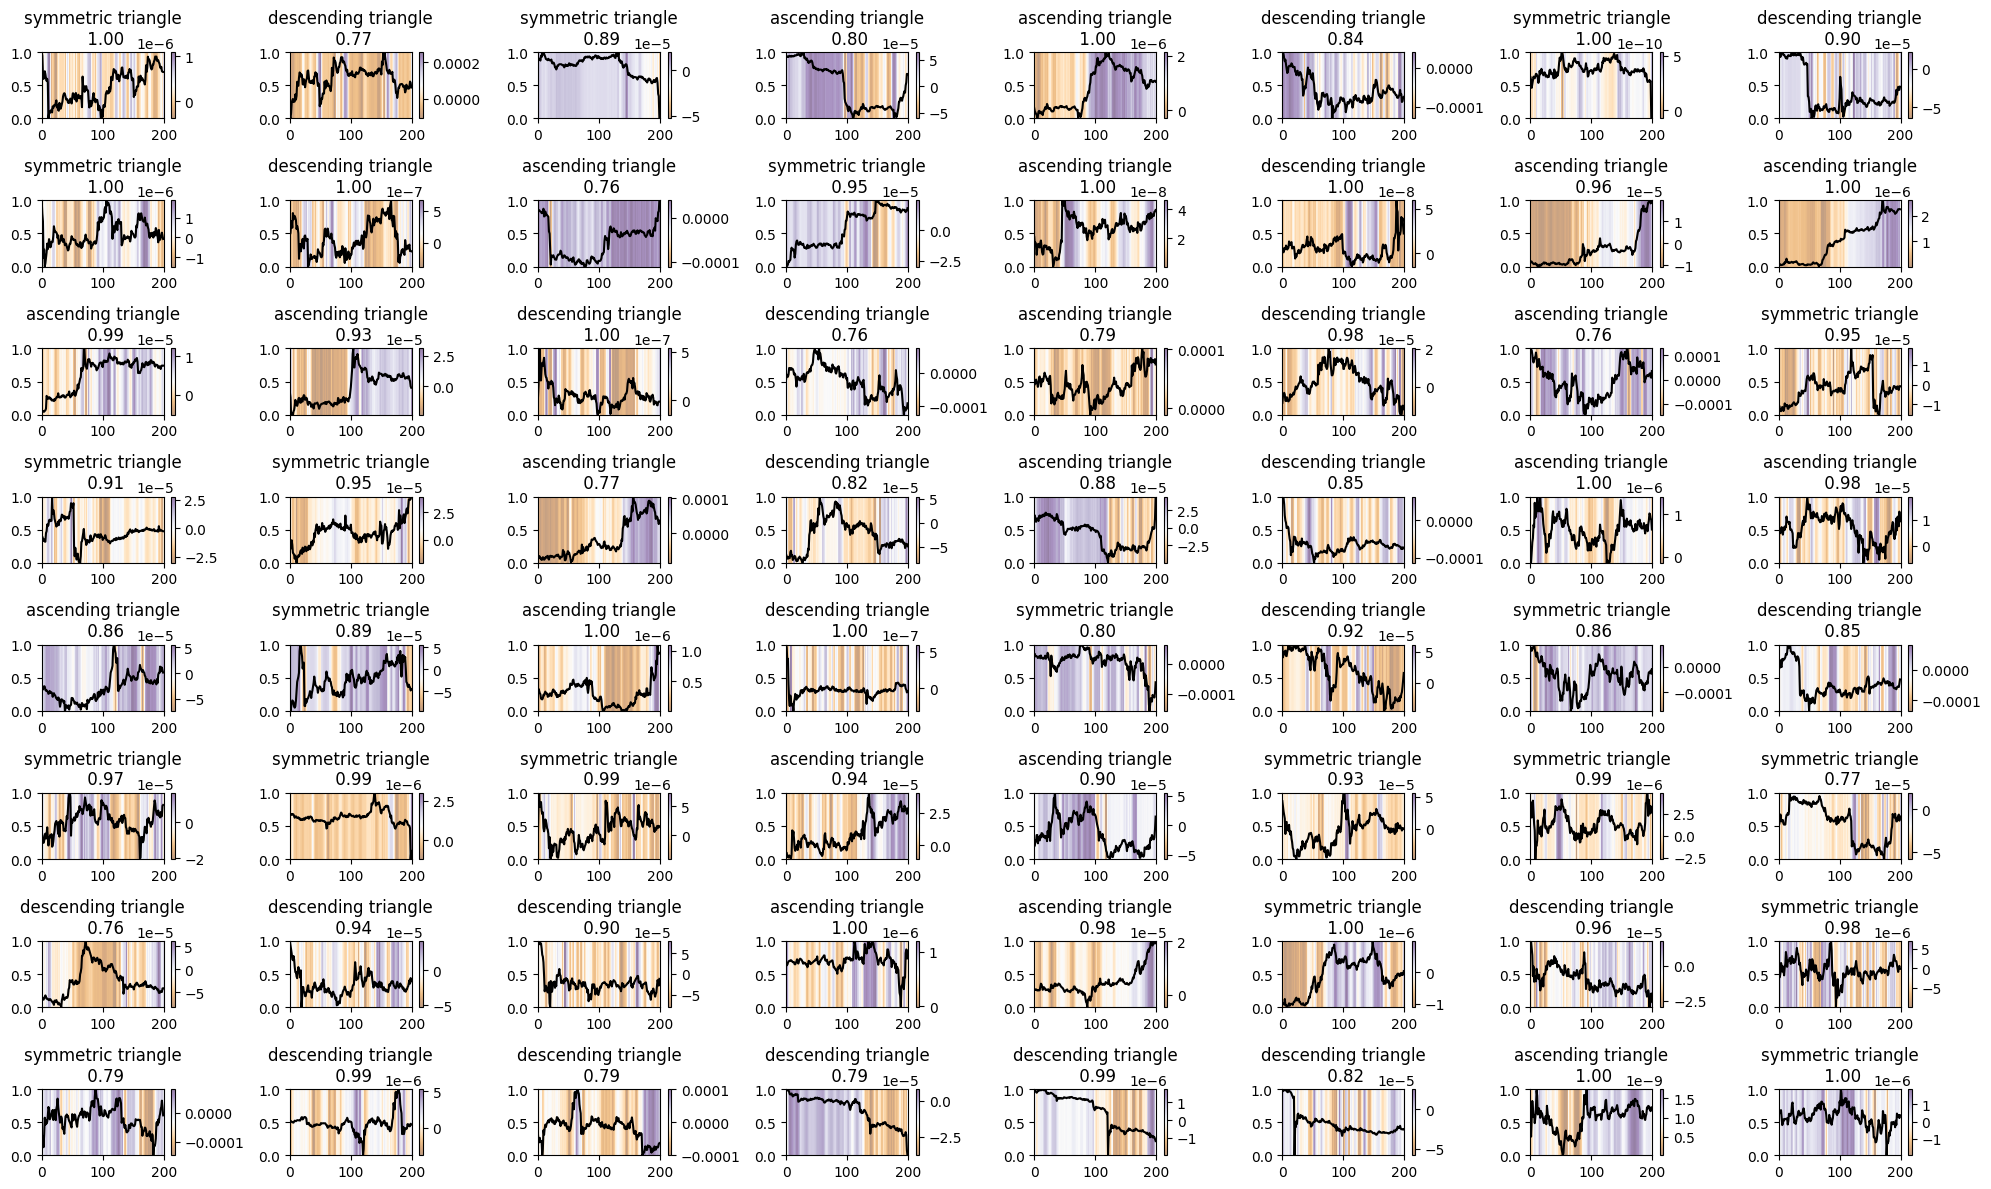

In [19]:
plt.figure(figsize=(20, 12))
draw_grid(dataset, WINDOW_SIZE, output, classes = classes, subplot_grid=(8,8))

In [9]:
import os
dataset = pd.read_csv("../static/datasets/pattern_dataset_reverent_raman/reverent_raman/dataset.csv", header=None).to_numpy()
dataset = tf.data.Dataset.from_tensor_slices(dataset)
dataset = dataset.batch(1).map(lambda windows: tf.expand_dims(windows, axis=-1))


In [10]:

output = model.predict(dataset)

    1/15000 [..............................] - ETA: 7:00

15000/15000 [==============================] - 73s 5ms/step


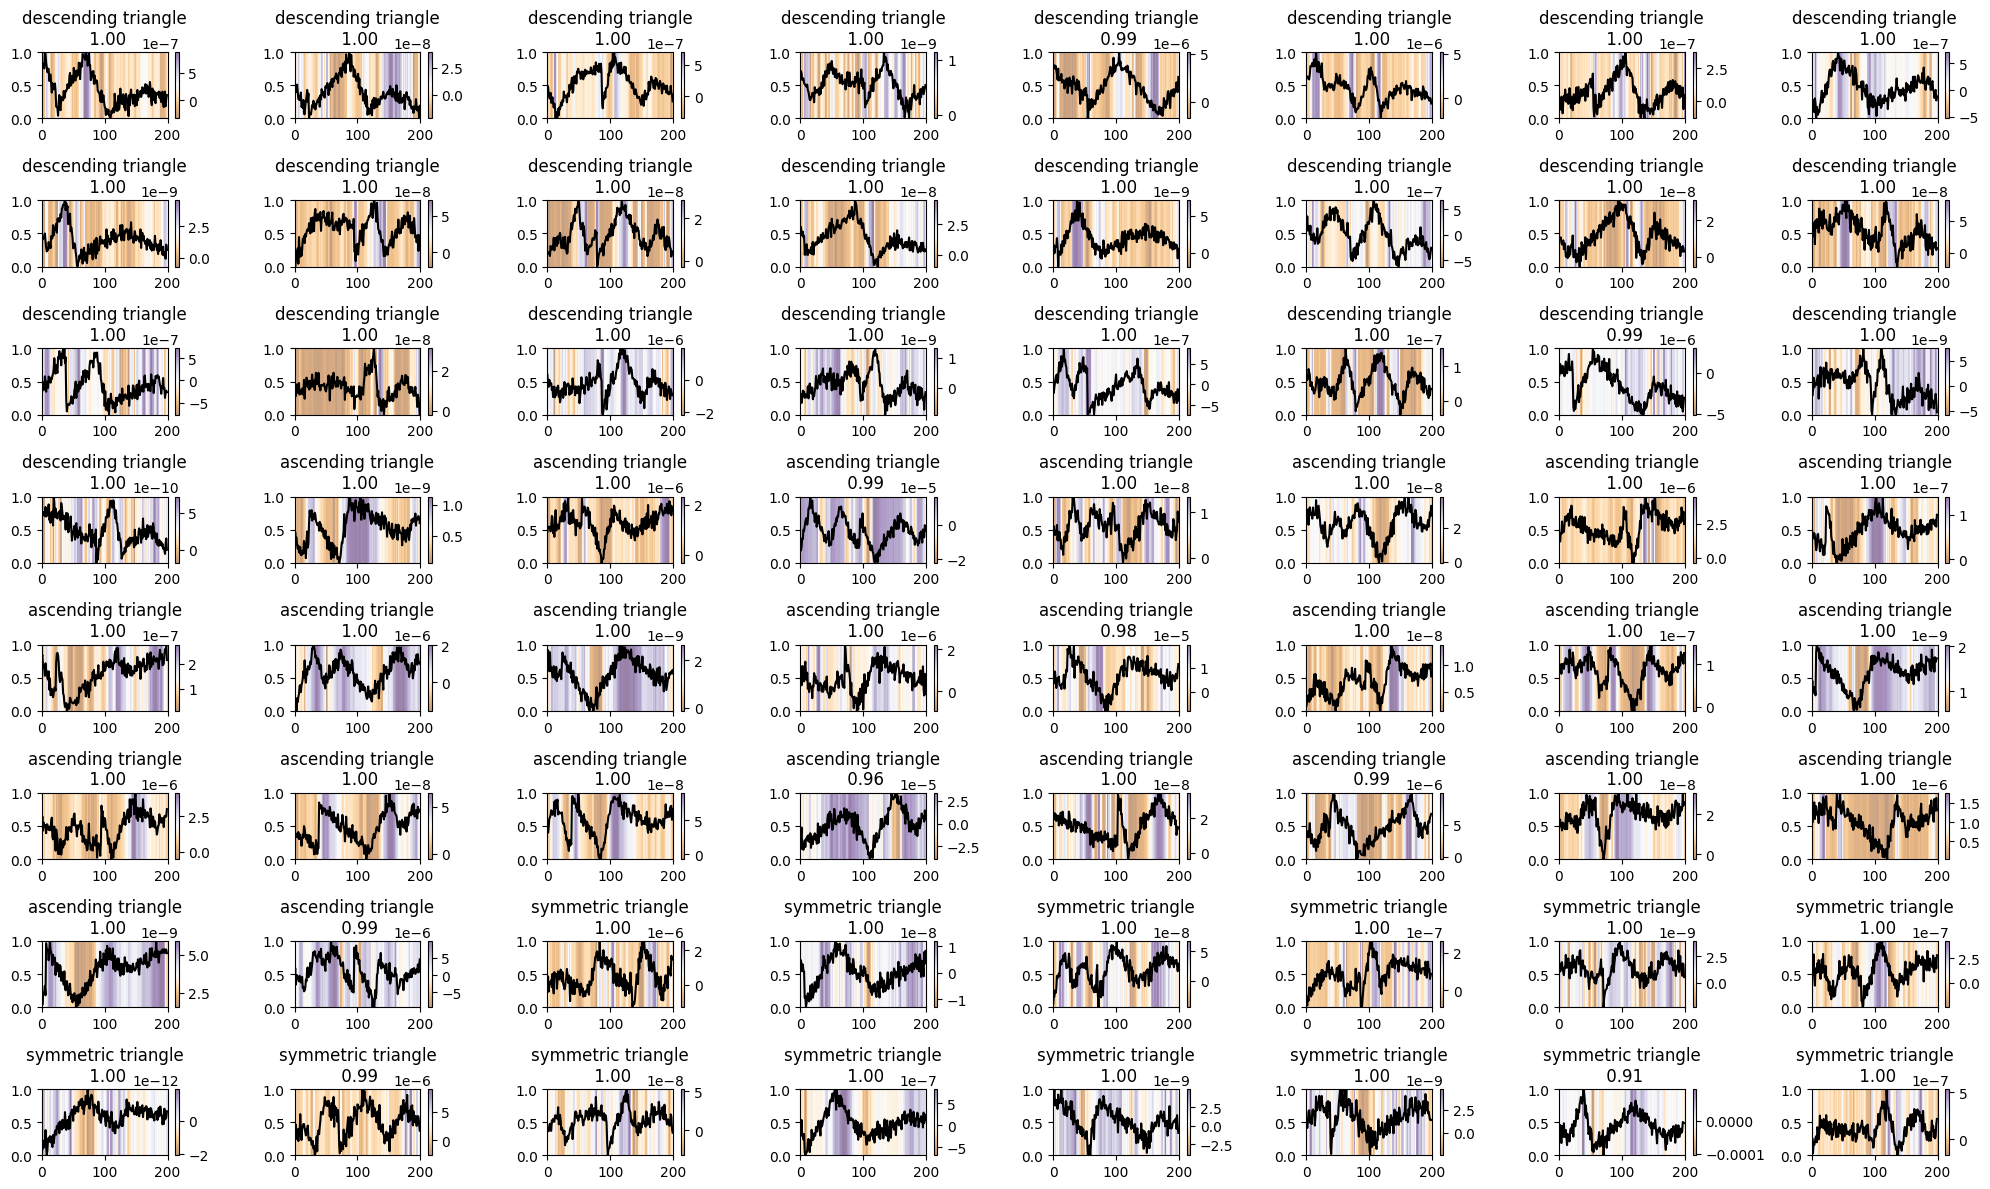

In [11]:
plt.figure(figsize=(20, 12))
draw_grid(dataset, WINDOW_SIZE, output, classes = classes, subplot_grid=(8,8))

In [21]:
predictions = pd.DataFrame(data = output[0], columns=['ascending', 'base',  'descending', 'symetric'])
predictions.describe()

,ascending,base,descending,symetric
count,7.801000e+03,7.801000e+03,7.801000e+03,7.801000e+03
mean,2.274826e-01,3.445839e-01,1.937926e-01,2.341409e-01
std,3.856451e-01,4.326382e-01,3.407028e-01,3.747577e-01
min,6.828509e-17,6.173921e-10,6.745543e-15,3.533629e-12
25%,1.463274e-06,2.239995e-04,2.991898e-04,1.837367e-04
50%,3.395213e-04,2.473155e-02,6.379424e-03,6.631969e-03
75%,2.883539e-01,9.294532e-01,1.760163e-01,3.396995e-01
max,9.999999e-01,9.999993e-01,9.999970e-01,1.000000e+00


In [63]:
import os
dataset3 = pd.read_csv("../static/datasets/pattern_dataset_real_data/dataset.csv", header=None)
labels = pd.read_csv("../static/datasets/pattern_dataset_real_data/labels.csv")
dataset3.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)

# Concatenate the DataFrames along columns (axis=1)
merged_df = pd.concat([dataset3, labels], axis=1)
merged_df = merged_df.dropna(how='any')
merged_df = merged_df[merged_df['position'] > 0]  

dataset3 = merged_df.drop(columns=list(labels.columns))
labels = merged_df[list(labels.columns)].copy()
dataset3 = tf.data.Dataset.from_tensor_slices(dataset3)
dataset3 = dataset3.batch(1).map(lambda windows: tf.expand_dims(windows, axis=-1))

123
130
104
104


In [64]:
output3 = model.predict(dataset3)

  1/104 [..............................] - ETA: 1s

104/104 [==============================] - 1s 5ms/step


In [65]:
match_df = labels.copy()
match_df['predicted'] = np.argmax(output3[0], axis=1)

In [82]:
labels

,name,position,width
3,ASCENDING_TRIANGLE,181.0,19.0
4,DESCENDING_PATTERN,186.0,14.0
5,DESCENDING_PATTERN,176.0,24.0
6,SYMETRIC_TRIANGLE,170.0,30.0
7,SYMETRIC_TRIANGLE,170.0,30.0
...,...,...,...
114,SYMETRIC_TRIANGLE,135.0,65.0
116,DESCENDING_PATTERN,178.0,22.0
117,DESCENDING_PATTERN,176.0,24.0
118,DESCENDING_PATTERN,170.0,30.0


In [84]:
match_df['name'] = labels['name']
mapping = {"ASCENDING_TRIANGLE": 0, "DESCENDING_PATTERN": 2, "SYMETRIC_TRIANGLE": 3}
match_df['code'] = match_df['name'].map(mapping)

In [86]:
print(match_df.loc[:, ['code', 'predicted']].to_string())

     code  predicted
3       0          0
4       2          0
5       2          1
6       3          2
7       3          0
8       3          3
9       0          0
10      3          0
11      2          0
13      2          3
14      2          1
15      3          1
16      2          0
17      0          2
18      0          0
19      2          0
20      2          1
21      2          0
22      3          1
23      0          0
24      0          1
25      2          3
26      2          0
27      3          2
28      2          0
29      3          0
30      2          3
31      2          2
32      3          3
33      2          1
34      0          0
35      3          1
36      2          0
37      2          1
38      0          3
39      2          0
40      3          1
41      2          0
42      2          2
43      3          1
45      2          3
46      2          1
47      2          3
48      0          1
49      2          3
51      3          1
52      3    

In [87]:
match_df['Match'] = match_df.predicted.eq(match_df.code)
dfa = match_df.groupby('code').Match.mean().mul(100).round(2)
dfa

code
0    38.24
2    14.29
3    10.71
Name: Match, dtype: float64

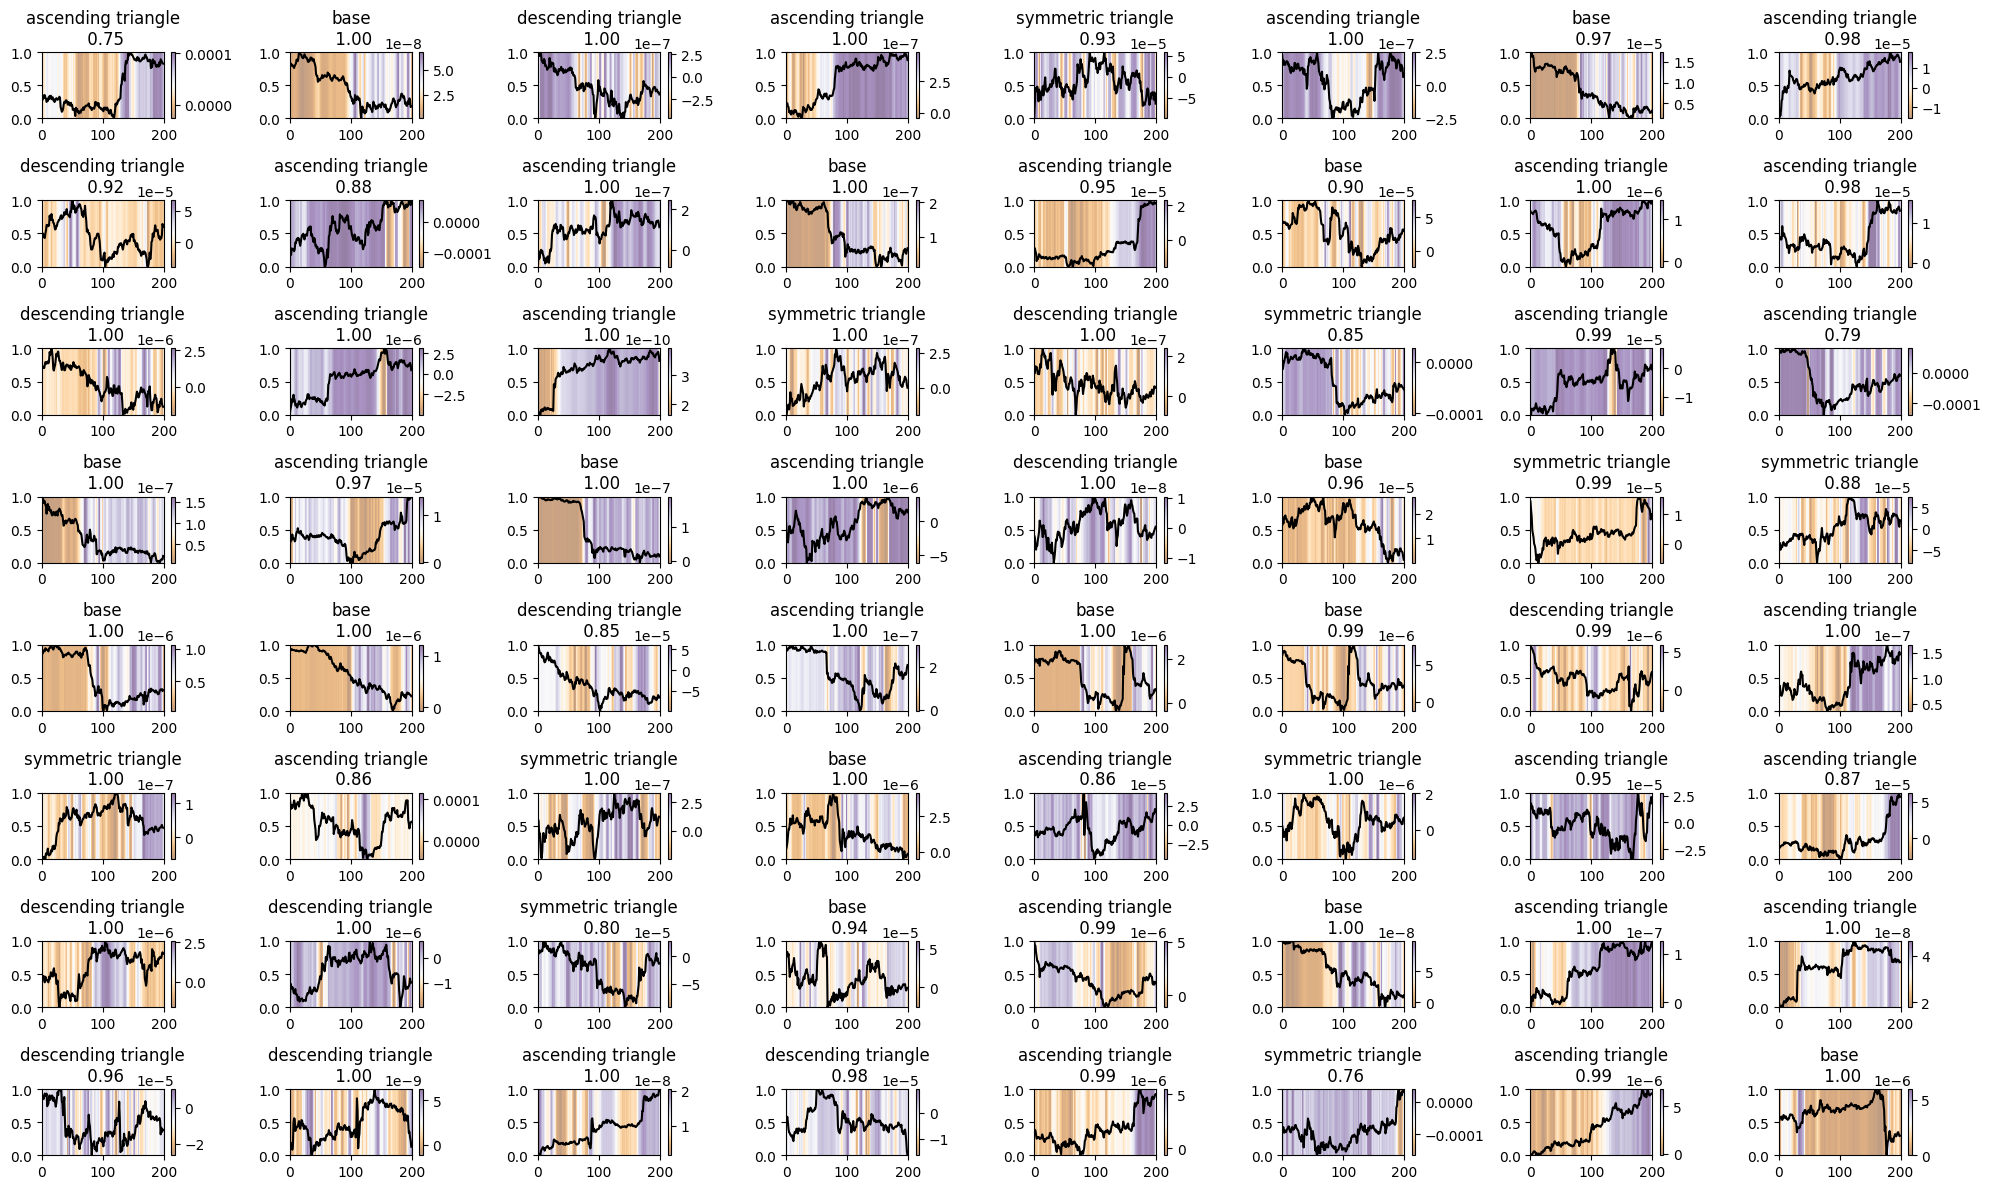

In [66]:
plt.figure(figsize=(20, 12))
draw_grid(dataset3, WINDOW_SIZE, output3, classes = classes, subplot_grid=(8,8), threshold=0.75, skip_after_found=0)